In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
import lightgbm as lgbm
import warnings

warnings.filterwarnings('ignore')

Достаточно много коллег по цеху жалуется на то, что с набором несколько тяжело начать работать <br />
в colab и, действительно, при считывании не хватает памяти. <br />
Большая проблема - нет чтения по батчам. <br />
Есть много разных WA, например, считать по колонкам, но одним <br />
из самых канонических подходов будет, пожалуй, использовать **Dask** <br />

1. Если **Dask** не был установлен, то нужно воспользоваться командой:
```
!pip install dask[dataframe]
```
2. Убедитесь, что данные доступны для ноутбука. В колабе это можно сделать примерно так
```
!wget https://boosters.pro/api/ch/files/pub/data_fusion_train.parquet
```

In [2]:
%%time
data = dd.read_parquet('../assets/data/raw/data_fusion_train.parquet').compute()

CPU times: user 18.2 s, sys: 5.58 s, total: 23.8 s
Wall time: 26.9 s


# Немного посмотрим на объем и тип данных

In [3]:
data.shape

(26094077, 9)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int64  
 1   receipt_dayofweek  int32  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float64
 5   item_price         int64  
 6   item_nds_rate      int32  
 7   category_id        int64  
 8   brands             object 
dtypes: float64(1), int32(2), int64(3), object(3)
memory usage: 1.7+ GB


Имеются "жирные" поля типа object, которые можно перекодировать для сокращения потребления памяти, <br />
если такой проблемы нет (памяти очень много), то можно двигаться дальше

In [5]:
data.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс
1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None
2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None
3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None
4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None


In [6]:
data.describe()

,receipt_id,receipt_dayofweek,item_quantity,item_price,item_nds_rate,category_id
count,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07,2.609408e+07
mean,5.008370e+06,3.079493e+00,1.413864e+09,8.723268e+00,2.315496e+00,2.537151e+01
std,2.891319e+06,1.989730e+00,5.106975e+12,3.769641e+00,2.240315e+00,5.376522e+01
min,2.000000e+00,0.000000e+00,1.000000e-03,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.505699e+06,1.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,-1.000000e+00
50%,5.008298e+06,3.000000e+00,1.000000e+00,9.000000e+00,2.000000e+00,-1.000000e+00
75%,7.511943e+06,5.000000e+00,1.000000e+00,1.100000e+01,4.000000e+00,-1.000000e+00
max,1.001617e+07,6.000000e+00,1.844674e+16,4.200000e+01,6.000000e+00,2.040000e+02


Опираясь на статистику по полям, приходим к выводам, <br />
что параметры по умолчанию уж очень много съедают памяти и <br />
нужно сократить их чем-то таким:

In [7]:
map_column_to_type = {
    'category_id': np.int16,
    'item_nds_rate': np.int16,
    'item_price': np.int16,
    'item_quantity': np.float32,
    'receipt_dayofweek': np.int16,
    'receipt_id': np.int32,
#     'receipt_time': pd.StringDtype(),
#     'item_name': pd.StringDtype(),
#     'brands': pd.StringDtype()
}

Забегая в перед, к сожалению, приведение receipt_time, item_name, brands - пришлось отложить, <br />
так как новый тип StringArray не подружился с CatBoost.

In [8]:
for key in map_column_to_type:
    data[key] = data[key].astype(map_column_to_type[key])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26094077 entries, 0 to 45729315
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   receipt_id         int32  
 1   receipt_dayofweek  int16  
 2   receipt_time       object 
 3   item_name          object 
 4   item_quantity      float32
 5   item_price         int16  
 6   item_nds_rate      int16  
 7   category_id        int16  
 8   brands             object 
dtypes: float32(1), int16(4), int32(1), object(3)
memory usage: 1.2+ GB


Видим теперь очень хорошее сокрощение потребления памяти (почти 500Mb)

# И совсем немного взглянем на данные...

In [10]:
count_category = data['category_id'].value_counts().reset_index()

In [11]:
count_category.columns = ['category', 'count']

In [12]:
pd.set_option('max.columns', 200)

In [13]:
count_category.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
category,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,3,177,133,120,50,36,62,52,57,19,20,29,114,42,37,12,31,4,150,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,12159,11764,10960,10836,9015,7838,6749,6160,5933,5774,5378,5298,4939,4804,4687,4657,4194,3930,3783,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


Помним "-1" - товары без определенной категории

Товары с категорий -1 - встречаться не будут в тесте, поэтому их можно удалить <br />
или отложить, чтобы переиспользовать каким-то образом. 

В своем baseline просто осводимся от них для простоты

In [14]:
data = data[data['category_id'] != -1]

In [15]:
data.shape

(6483226, 9)

Набор значительно сократился, давай продолжим его сокращать!

По информации из чата известно, что метрика будет рассчитываться <br />
на уникальных товарах (отличаются по item_name) 

In [16]:
data[data['item_name'].duplicated()]

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands
150,356,2,13:07,Пакет,1.0,3,6,203,None
185,558,1,13:55,Пакет,1.0,3,6,203,None
195,562,5,15:29,Пакет,1.0,0,1,203,None
226,674,6,13:19,Пакет,1.0,2,6,203,None
491,1005,5,22:20,Пакет,1.0,3,1,203,None
...,...,...,...,...,...,...,...,...,...
45729256,10016106,6,12:18,Мороженое ЗОЛОТОЙ СТАНДАРТ рож,1.0,9,2,73,None
45729264,10016106,6,12:18,Пакет,1.0,3,1,203,None
45729277,10016136,6,17:08,Пакет,1.0,3,1,203,None
45729279,10016149,1,11:08,Печень по-строгановски,1.0,8,1,71,None


Видим, что основная часть данных просто дубликаты! <br />
Т.к. мы уже выбрали модель - boosting и знаем, что он не хранит состояние. <br />
Нам нужно делать предсказание категории относительно одной и той же сущност: <br />

```
150	356	2	13:07	Пакет	1.0	3	6	203	<NA>
185	558	1	13:55	Пакет	1.0	3	6	203	<NA>
``` 
Одна и та же сущность - пакет, но она представлена разными точками данных, <br />
Для нас это будет шумом, поэтому такие дубликаты нужно убрать каким-то способом -

можно просто удалить, например, так:

```
    df_uni = data[data.category_id != -1].drop_duplicates('item_name')
```

но лучше усреднить данные, чтобы получить "среднюю сущность"


In [17]:
gr_item_name = data.groupby('item_name')
data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
data['std_item_price'] = gr_item_name['item_price'].transform("std")
data['min_item_price'] = gr_item_name['item_price'].transform("min")
data['max_item_price'] = gr_item_name['item_price'].transform("max")

data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

data['mean_hours'] = gr_item_name['hours'].transform("mean")
data['sum_hours'] = gr_item_name['hours'].transform("sum")
data['std_hours'] = gr_item_name['hours'].transform("std")
data['min_hours'] = gr_item_name['hours'].transform("min")
data['max_hours'] = gr_item_name['hours'].transform("max")


data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)

In [18]:
df_uni = data.drop_duplicates('item_name')

In [19]:
df_uni.shape

(48225, 31)

Размер внушительно уменьшился!

## А давай-ка посмотрим на самых ярких представителей своих классов...

Если у тебя не было нужных либ, то выполни команду:
  ```
   pip install wordcloud
  ```

In [20]:
!pip install wordcloud

In [20]:
count_category.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
category,-1,203,84,80,78,71,83,77,69,204,79,38,74,70,81,0,40,73,130,76,139,75,85,145,117,82,92,61,68,51,72,67,7,30,66,49,2,118,45,43,3,177,133,120,50,36,62,52,57,19,20,29,114,42,37,12,31,4,150,103,140,41,9,138,96,107,167,163,109,128,6,27,115,53,90,26,11,164,60,24,13,105,56,101,111,39,35,102,54,55,108,58,100,1,106,97,46,143,121
count,19610851,1307260,902507,670833,503199,422085,322656,193369,186312,136271,126837,126410,101648,94482,93440,92280,88427,88121,80566,80476,71907,69004,67961,64365,55324,45508,41629,39821,30077,26690,24865,21723,17756,17168,16823,16274,15502,15353,14597,14362,12159,11764,10960,10836,9015,7838,6749,6160,5933,5774,5378,5298,4939,4804,4687,4657,4194,3930,3783,3695,3252,2871,2569,2565,2443,2377,2064,2042,1988,1914,1814,1787,1710,1646,1642,1470,1435,1388,1158,1149,801,741,690,626,612,507,480,459,456,444,406,356,312,226,183,109,67,25,1


In [21]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [22]:
def get_text_all_category(data, category_id):
    text = " "
    category = data[data.category_id == category_id]
    for idx, row in tqdm(category.iterrows(), total=category.shape[0]):
        text += row['item_name'] + " "
    return text

def plot_category(data, category_id, figsize=(7, 5)):
    plt.figure(figsize=figsize)
    category = get_text_all_category(data, category_id)
    wordcloud = WordCloud(max_font_size=40).generate(category)
    print(f'Category: {category_id}')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Category: 203


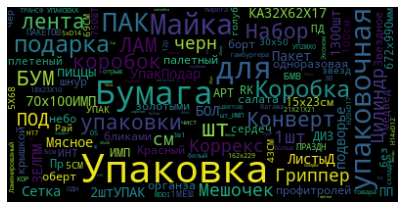

In [23]:
plot_category(df_uni, 203)


Category: 35


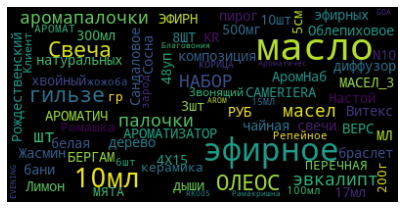

In [24]:
plot_category(df_uni, 35)


Category: 46


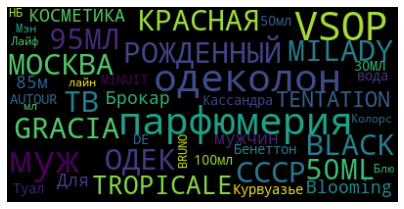

In [25]:
plot_category(df_uni, 46)


Category: 100


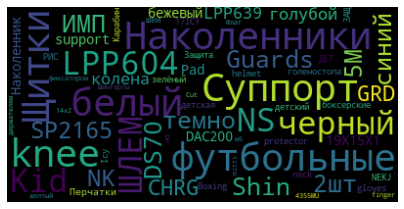

In [26]:
plot_category(df_uni, 100)


Category: 101


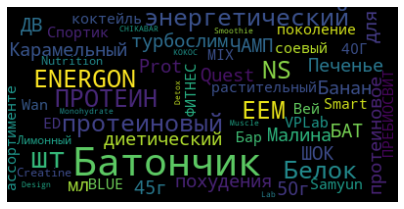

In [27]:
plot_category(df_uni, 101)

Посмотрели немного данные, теперь предлагаю перейти к моделированию. <br />
В качестве модели для разнородных данных, типа наших, подходит бустинг - в нашем случае будет - CatBoost. <br />
Благодаря относительно новым возможностям, CatBoost позволяет сразу использовать все разнородные признаки <br />

**Не забывай, что нам также нужна "хорошая" валидация, иначе рискуем просто улететь на привате!**

In [28]:
train, valid = model_selection.train_test_split(df_uni,
                                                test_size=0.10, 
                                                stratify=df_uni['category_id'], 
                                                shuffle=True, random_state=10)

In [29]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek
216804,474787,3,10:37,EGOISTE ESPRESSO МОЛ,1.0,13,1,84,egoiste,1.285714,27.0,0.643650,1.0,3.0,13.142857,276.0,0.358569,13,14,1.0,21.0,0.0,1,1,10,14.809524,311,3.400280,8,21,2
12663919,7717680,5,13:56,ПОДСВЕТКА НЕОНОВАЯ 1 МЕТР БЕЛАЯ 12-24 В,1.0,14,1,128,None,1.333333,4.0,0.577350,1.0,2.0,14.000000,42.0,0.000000,14,14,1.0,3.0,0.0,1,1,13,15.666667,47,4.618802,13,21,5
852935,1877634,4,20:13,КАПУСТА КВАШ КИСЛО-СЛАДКАЯ 1КГ,1.0,11,1,75,None,1.223881,82.0,0.755202,1.0,6.0,10.985075,736.0,0.122169,10,11,1.0,67.0,0.0,1,1,20,14.611940,979,4.441387,4,22,4
3182690,6969354,1,08:25,Энергетический напиток С.О.В.А. Апельсин,1.0,10,1,83,None,1.000000,3.0,0.000000,1.0,1.0,10.000000,30.0,0.000000,10,10,1.0,3.0,0.0,1,1,8,14.666667,44,6.110101,8,20,1
1554564,3411092,5,12:08,"Растворитель Р-4 0,5л ЯСХИМ",1.0,10,6,108,ясхим,1.076923,14.0,0.277350,1.0,2.0,9.615385,125.0,0.506370,9,10,6.0,78.0,0.0,6,6,12,13.384615,174,2.180920,11,18,4


CatBoost позволяет сразу принять <br />
и *числовые признаки*, <br />
и *категории*, <br />
и даже *текст*

In [30]:
print(list(train.columns))

['receipt_id', 'receipt_dayofweek', 'receipt_time', 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 'category_id', 'brands', 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 'min_item_quantity', 'max_item_quantity', 'mean_item_price', 'sum_item_price', 'std_item_price', 'min_item_price', 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 'hours', 'mean_hours', 'sum_hours', 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek']


In [58]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek'] #+ feature_probs

cat_features = ['receipt_time', 'receipt_id']
text_features = ['item_name']

target = 'category_id'

Зададим гиперпараметры: если верить разным докладам от Яндекса, то у CatBoost 2 крайне важных гиперпараметра:
1. Число деревьев
2. Learning rate

Если есть GPU, то можно еще и время ожидания сократить в разы - нужно добавить
```
   task_type='GPU'
```

TotalF1 - как раз нам подходит в качестве метрики (взвешенный F1)

In [59]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,            
)

In [60]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1407685	test: 0.1391385	best: 0.1391385 (0)	total: 148ms	remaining: 2m 27s
50:	learn: 0.6271089	test: 0.6567197	best: 0.6567197 (50)	total: 6.83s	remaining: 2m 7s
100:	learn: 0.6491005	test: 0.6704070	best: 0.6711898 (99)	total: 13.3s	remaining: 1m 58s
150:	learn: 0.6647316	test: 0.6774204	best: 0.6779028 (148)	total: 19.8s	remaining: 1m 51s
200:	learn: 0.6754147	test: 0.6852048	best: 0.6852048 (200)	total: 26.5s	remaining: 1m 45s
250:	learn: 0.6841280	test: 0.6837681	best: 0.6852048 (200)	total: 33s	remaining: 1m 38s
300:	learn: 0.6929885	test: 0.6848704	best: 0.6881399 (289)	total: 39.6s	remaining: 1m 31s
350:	learn: 0.6997541	test: 0.6859583	best: 0.6881399 (289)	total: 46.2s	remaining: 1m 25s
400:	learn: 0.7051281	test: 0.6872007	best: 0.6886175 (388)	total: 52.7s	remaining: 1m 18s
450:	learn: 0.7119911	test: 0.6896106	best: 0.6903185 (442)	total: 59.3s	remaining: 1m 12s
500:	learn: 0.7175727	test: 0.6910334	best: 0.6928734 (480)	total: 1m 5s	remaining: 1m 5s
550:	learn

Легким движением руки (в fit установить флаг plot=True) - и мы можем отслеживать <br>
необходимые показатели при обучении. <br />

"Хорошее" число итераций советуют брать на уровне зеленой точки. <br />
Крайне важно, чтобы точка не была полностью в конце либо далеко от конца.

Судя по графику - у нас пошло переобучение (небольшое)
В реальном мире, скорее всего мы бы остановились на 300 итерациях, где у нас <br />
показатели на тренировке и валидации близки - предпочтение ушло бы более стабильной модели.

Но здесь конкурс, поэтому хотим выжать все соки, конечно, стараемся не получать очень большого <br />
разброса. например, с помощью регуляризации, но все же позволяем модельке чуть переобучиться, чтобы получить больше показатели, но менее стабильную модель (может на привате быть менее хороша)

# А поиграемся с текстом

In [56]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 
                 'last_first_word',
                ] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']

target = 'category_id'
                

In [57]:
train.head()

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek,first,last,is_preservativ,is_auto,is_paper,is_otkritka,is_born,is_a4,is_ubiley,is_list,is_kanc,is_dnevnik,second_last_word,second_first_word,first_word_len,last_word_len,item_name_len,last_first_word
216804,474787,3,10:37,EGOISTE ESPRESSO МОЛ,1.0,13,1,84,egoiste,1.285714,27.0,0.643650,1.0,3.0,13.142857,276.0,0.358569,13,14,1.0,21.0,0.0,1,1,10,14.809524,311,3.400280,8,21,2,EGOISTE,МОЛ,0,0,0,0,0,0,0,0,0,0,ESPRESSO,ESPRESSO,7,3,3,МОЛEGOISTE
12663919,7717680,5,13:56,ПОДСВЕТКА НЕОНОВАЯ 1 МЕТР БЕЛАЯ 12-24 В,1.0,14,1,128,None,1.333333,4.0,0.577350,1.0,2.0,14.000000,42.0,0.000000,14,14,1.0,3.0,0.0,1,1,13,15.666667,47,4.618802,13,21,5,ПОДСВЕТКА,В,0,0,0,0,0,0,0,0,0,0,12-24,НЕОНОВАЯ,9,1,7,ВПОДСВЕТКА
852935,1877634,4,20:13,КАПУСТА КВАШ КИСЛО-СЛАДКАЯ 1КГ,1.0,11,1,75,None,1.223881,82.0,0.755202,1.0,6.0,10.985075,736.0,0.122169,10,11,1.0,67.0,0.0,1,1,20,14.611940,979,4.441387,4,22,4,КАПУСТА,1КГ,0,0,0,0,0,0,0,0,0,0,КИСЛО-СЛАДКАЯ,КВАШ,7,3,4,1КГКАПУСТА
3182690,6969354,1,08:25,Энергетический напиток С.О.В.А. Апельсин,1.0,10,1,83,None,1.000000,3.0,0.000000,1.0,1.0,10.000000,30.0,0.000000,10,10,1.0,3.0,0.0,1,1,8,14.666667,44,6.110101,8,20,1,Энергетический,Апельсин,0,0,0,0,0,0,0,0,0,0,С.О.В.А.,напиток,14,8,4,АпельсинЭнергетический
1554564,3411092,5,12:08,"Растворитель Р-4 0,5л ЯСХИМ",1.0,10,6,108,ясхим,1.076923,14.0,0.277350,1.0,2.0,9.615385,125.0,0.506370,9,10,6.0,78.0,0.0,6,6,12,13.384615,174,2.180920,11,18,4,Растворитель,ЯСХИМ,0,0,0,0,0,0,0,0,0,0,"0,5л",Р-4,12,5,4,ЯСХИМРастворитель


У CatBoost'a есть возможность обрабатывать текст из коробки, для этого нужно лишь указать, эту текстовую колонку:

```
text_features=[name_your_text_feature]
```
Так же модели нужно сообщить какие из колонок считать категориальными
```
cat_features=[your_categorical_feature]
```
Учтите, что категориальные переменные не должны содержать Nan зачений - CatBoost не поддерживает из коробки их 
заполнение, а вот если Nan есть в числовых значениях, работает очень даже хорошо.


В работе CatBoost'a есть 3 этапа:
1. Токенизация
2. Создание словаря
3. Подсчет признаков


Конфигурировать весь процесс можно через text_processing, передав вложенный словарь.

Для простоты:
1. токенизация будет по пробелу (нужно задать токенизатор)
2. создадим 2-6 gram'ы (нужно создать соответствующие словари)
3. выполним подсчет признаков (укажим какие признаки подсчитываем на словаре)


Пример словаря: 

```
{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
}
```

Создали словарь 3-грам (gram_order - этот параметр определяет какой вид n-gram'a создается),
на символах (token_level_type, поддерживается еще уровень Word),
нижняя граница частоты 3-граммы равна 1 (occurrence_lower_bound),
так же нужно указать размер словаря (это скажется на предварительных подсчетах)


Затем нужно посчитать признаки. CatBoost позволяет считать 3 вида признаков:
1. Bow (Bag-of-Words)
2. NaiveBayes 
3. BM25 

[Про эти особенности можно почитать здесь](https://catboost.ai/docs/search/?query=BM25)
        
И [более понятно на примерах здесь](https://github.com/catboost/tutorials/blob/master/text_features/text_features_in_catboost.ipynb)

In [35]:
model = CatBoostClassifier(
    cat_features=cat_features,
    text_features=text_features,
    verbose=50,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,      
#     reg_lambda=0.0001,
    
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)



In [36]:
def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data

In [37]:
train = create_features(train)

valid = create_features(valid)

# Посмотрим, нет ли у нас пропусков, так как поиск std часто их дает

In [38]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity      7315
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price         7315
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate      7315
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours              7315
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

Как и ожидалось, пропуски есть - заполним их медианой

In [39]:
def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

In [40]:
train = fill_median(train)
valid = fill_median(valid)

In [41]:
train.isnull().sum()

receipt_id                0
receipt_dayofweek         0
receipt_time              0
item_name                 0
item_quantity             0
item_price                0
item_nds_rate             0
category_id               0
brands                36704
mean_item_quantity        0
sum_item_quantity         0
std_item_quantity         0
min_item_quantity         0
max_item_quantity         0
mean_item_price           0
sum_item_price            0
std_item_price            0
min_item_price            0
max_item_price            0
mean_item_nds_rate        0
sum_item_nds_rate         0
std_item_nds_rate         0
min_item_nds_rate         0
max_item_nds_rate         0
hours                     0
mean_hours                0
sum_hours                 0
std_hours                 0
min_hours                 0
max_hours                 0
median_dayofweek          0
first                     0
last                      0
is_preservativ            0
is_auto                   0
is_paper            

In [44]:
model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1755967	test: 0.1897938	best: 0.1897938 (0)	total: 289ms	remaining: 4m 48s
50:	learn: 0.7052533	test: 0.7395048	best: 0.7395048 (50)	total: 12.2s	remaining: 3m 46s
100:	learn: 0.7390728	test: 0.7651854	best: 0.7659653 (97)	total: 23.9s	remaining: 3m 32s
150:	learn: 0.7625084	test: 0.7738773	best: 0.7740864 (149)	total: 36.1s	remaining: 3m 22s
200:	learn: 0.7811714	test: 0.7805735	best: 0.7805735 (200)	total: 48.4s	remaining: 3m 12s
250:	learn: 0.7997546	test: 0.7872413	best: 0.7872413 (250)	total: 1m	remaining: 3m 1s
300:	learn: 0.8146703	test: 0.7892521	best: 0.7892521 (300)	total: 1m 12s	remaining: 2m 49s
350:	learn: 0.8287127	test: 0.7925444	best: 0.7945387 (331)	total: 1m 24s	remaining: 2m 36s
400:	learn: 0.8417842	test: 0.7944028	best: 0.7945387 (331)	total: 1m 36s	remaining: 2m 24s
450:	learn: 0.8537010	test: 0.7958459	best: 0.7963220 (420)	total: 1m 48s	remaining: 2m 12s
500:	learn: 0.8649109	test: 0.7959619	best: 0.7964647 (490)	total: 2m	remaining: 2m
550:	learn: 0

In [49]:
import pickle
from sklearn.metrics import classification_report

In [50]:
print(classification_report(valid.category_id.values, model.predict(valid[feature_names])))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       236
           1       1.00      0.67      0.80         3
           2       0.96      0.81      0.88        32
           3       1.00      1.00      1.00        11
           4       0.63      0.52      0.57        23
           6       1.00      0.50      0.67         6
           7       1.00      0.95      0.98        22
           9       0.91      1.00      0.95        10
          11       1.00      0.20      0.33         5
          12       0.80      0.67      0.73        18
          13       1.00      0.25      0.40         4
          19       0.75      0.43      0.55         7
          20       1.00      0.67      0.80         6
          24       1.00      0.14      0.25         7
          26       0.00      0.00      0.00         2
          27       0.33      0.25      0.29         4
          29       0.91      0.77      0.83        13
          30       0.53    

Если посмотреть на confusion matrix, то видим, что достаточно много контраста - некоторые классы определены 
с высокой точностью, но некоторые классы определены как 0. Прослеживается некоторая связь между количеством
записей на валидации и в целом точностью, но т.к. наша модель крайне близко предсказывает локально и удаленно, <br>
то это говорит о близости входных распределений на тесте и трейне. Нужно поработать над предсказанием классов с низкими показателями.

Как это можно сделать?
1. Разметить неразмеченные данные, хотя бы частично
2. Добавить признаки, посчитанные вручную - boosting открывает широко двери в этом направлении
3. Улучшить токенизацию

# Кто на свете всех главнее?

In [45]:
importance = model.get_feature_importance(prettified=True)
importance

,Feature Id,Importances
0,item_name,78.355751
1,first,4.646711
2,last_first_word,2.918687
3,second_first_word,2.341052
4,second_last_word,1.502348
5,last,1.463578
6,mean_item_price,1.171593
7,receipt_id,0.935909
8,max_item_nds_rate,0.566866
9,min_hours,0.566571


В целом, было очень ожидаемо, что именно item_name будет самым главным признаком. <br>
Очень хорошо зашли категориальные признаки.

Давайте проведем анализ: где модель ошибается чаще всего. <br>
Для этого возьмем жирный класс 84, статистика которого будет более-менее показательной

In [48]:
valid['pred'] = model.predict(valid[feature_names])

In [51]:
valid[valid['category_id'] == 84].sample(50)

,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,mean_item_quantity,sum_item_quantity,std_item_quantity,min_item_quantity,max_item_quantity,mean_item_price,sum_item_price,std_item_price,min_item_price,max_item_price,mean_item_nds_rate,sum_item_nds_rate,std_item_nds_rate,min_item_nds_rate,max_item_nds_rate,hours,mean_hours,sum_hours,std_hours,min_hours,max_hours,median_dayofweek,first,last,is_preservativ,is_auto,is_paper,is_otkritka,is_born,is_a4,is_ubiley,is_list,is_kanc,is_dnevnik,second_last_word,second_first_word,first_word_len,last_word_len,item_name_len,last_first_word,pred
1284636,2816260,0,13:03,Слойка с сыром и ветч. 170гр,2.000,8,6,84,None,1.526316,58.000000,0.725476,1.000,4.000,8.000000,304.0,0.000000,8,8,6.000000,228.0,0.000000,6,6,13,12.815789,487,4.853838,3,22,2,Слойка,170гр,0,0,0,0,0,0,0,0,0,0,ветч.,с,6,5,6,170грСлойка,84
125734,276690,4,20:26,Пряники НОРМА классические 400,1.000,8,1,84,None,1.122807,64.000000,0.502500,1.000,4.000,8.473684,483.0,1.240755,0,9,1.000000,57.0,0.000000,1,1,20,15.877193,905,4.040289,8,23,3,Пряники,400,0,0,0,0,0,0,0,0,0,0,классические,НОРМА,7,3,4,400Пряники,84
13625741,9834961,3,19:29,Хлебобулочное изделие с отрубями 260гр Компани...,1.000,6,1,84,None,1.000000,6.000000,0.000000,1.000,1.000,6.000000,36.0,0.000000,6,6,1.000000,6.0,0.000000,1,1,19,14.333333,86,5.645057,9,23,4,Хлебобулочное,Хлеб,0,0,0,0,0,0,0,0,0,0,Забайкальский,изделие,13,4,8,ХлебХлебобулочное,84
33975448,4294383,6,22:21,ЛИМОНЧЕЛЛО,7.000,14,-1,84,None,7.000000,14.000000,0.000000,7.000,7.000,14.000000,28.0,0.000000,14,14,-1.000000,-2.0,0.000000,-1,-1,22,11.500000,23,14.849242,1,22,6,ЛИМОНЧЕЛЛО,ЛИМОНЧЕЛЛО,0,0,0,0,0,0,0,0,0,0,none,none,10,10,1,ЛИМОНЧЕЛЛОЛИМОНЧЕЛЛО,0
1830637,4022783,1,20:03,ХЛЕБЦЫ ЩЕДРЫЕ 100ГР В АССОРТ. ЛЕНИНГРАД. ОБЛ.,1.000,9,-1,84,None,1.000000,7.000000,0.000000,1.000,1.000,8.428571,59.0,0.534522,8,9,-1.000000,-7.0,0.000000,-1,-1,20,13.857143,97,4.413184,8,20,1,ХЛЕБЦЫ,ОБЛ.,0,0,0,0,0,0,0,0,0,0,ЛЕНИНГРАД.,ЩЕДРЫЕ,6,4,7,ОБЛ.ХЛЕБЦЫ,84
158748,349686,6,13:39,МИНИ-СУШКИ ПРОСТ.200,1.000,7,2,84,None,1.241176,211.000000,0.591417,1.000,5.000,7.000000,1190.0,0.000000,7,7,2.000000,340.0,0.000000,2,2,13,15.688235,2667,3.987018,2,23,3,МИНИ-СУШКИ,ПРОСТ.200,0,0,0,0,0,0,0,0,0,0,МИНИ-СУШКИ,ПРОСТ.200,10,9,2,ПРОСТ.200МИНИ-СУШКИ,84
289148,631364,3,14:36,Хлеб Ржаной 530г,1.000,7,6,84,None,1.080838,361.000000,0.304212,1.000,3.000,7.000000,2338.0,0.000000,7,7,6.000000,2004.0,0.000000,6,6,14,14.296407,4775,3.536025,1,22,3,Хлеб,530г,0,0,0,0,0,0,0,0,0,0,Ржаной,Ржаной,4,4,3,530гХлеб,84
136760,300796,5,11:43,Шоколад Альпен Гольд клубника/йогурт 90 г,1.000,7,1,84,None,1.040000,78.000000,0.197279,1.000,2.000,7.413333,556.0,0.699292,7,9,1.066667,80.0,0.577350,1,6,11,15.146667,1136,4.314317,1,22,3,Шоколад,г,0,0,0,0,0,0,0,0,0,0,90,Альпен,7,1,6,гШоколад,78
27443,61186,3,14:28,хлеб пшеничный,0.074,11,6,84,None,1.692527,2411.851074,2.503889,0.017,82.000,3.613333,5149.0,3.413451,2,11,1.955789,2787.0,1.968540,-1,6,14,12.102456,17246,5.956952,0,23,3,хлеб,пшеничный,0,0,0,0,0,0,0,0,0,0,хлеб,пшеничный,4,9,2,пшеничныйхлеб,84
28798062,2980548,1,16:56,СОЧНИ 1 ШТ,1.000,6,6,84,None,1.000000,6.000000,0.000000,1.000,1.000,6.000000,36.0,0.000000,6,6,6.000000,36.0,0.000000,6,6,16,17.000000,102,2.966479,14,21,1,СОЧНИ,ШТ,0,0,0,0,0,0,0,0,0,0,1,1,5,2,3,ШТСОЧНИ,84


Ошибаемся мы с 71, 78, 0 классами. <br>
Давайте посмотрим на основных представителей этих классов, возможно, это позволит понять причины ошибок модели



Category: 84


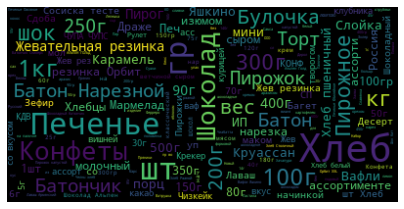

In [52]:
plot_category(df_uni, 84)


Category: 71


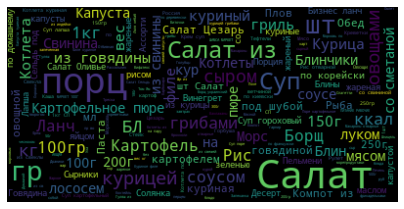

In [53]:
plot_category(df_uni, 71)


Category: 78


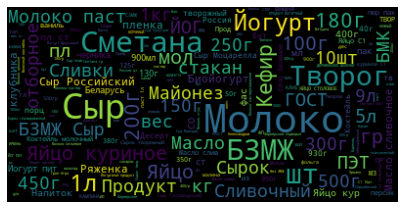

In [54]:
plot_category(df_uni, 78)


Category: 0


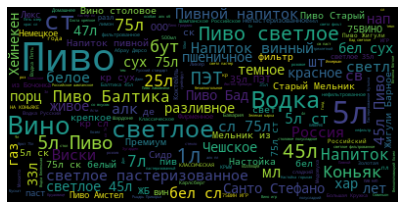

In [55]:
plot_category(df_uni, 0)

Видим, что здесь алкогольный напиток и он больше подходит к категории 0, чем к категории 84.
Скорее всего ошибка в разметке, которая добавляет шум и мешает модели - нужно исправить

```
33975448	4294383	6	22:21	ЛИМОНЧЕЛЛО	7.000	14	-1	84	
```

84, 71, 78 - все продукты питания, из разных категорий, но сложно провести точные границы, где будет заканчиваться один продукт и начинаться другой. Здесь с проверкой придется повозиться

# А заверните мне...

Сделаем все просто - создадим папку build, туда сохраним модель, script.py и упакуем тут же

In [85]:
!mkdir build 

mkdir: cannot create directory ‘build’: File exists


In [90]:
folder = 'build'

In [91]:
with open(f'{folder}/catboost.clf', 'wb') as f:
    f.write(pickle.dumps(model))

In [99]:
%%writefile build/script.py

import pandas as pd
import numpy as np
import pickle


feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 'last_first_word'] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']


def create_features_part_1(data):
    gr_item_name = data.groupby('item_name')
    data['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
    data['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
    data['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
    data['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
    data['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

    data['mean_item_price'] = gr_item_name['item_price'].transform("mean")
    data['sum_item_price'] = gr_item_name['item_price'].transform("sum")
    data['std_item_price'] = gr_item_name['item_price'].transform("std")
    data['min_item_price'] = gr_item_name['item_price'].transform("min")
    data['max_item_price'] = gr_item_name['item_price'].transform("max")

    data['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
    data['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
    data['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
    data['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
    data['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


    data['hours'] = data['receipt_time'].apply(lambda x: int(x.split(":")[0]))

    data['mean_hours'] = gr_item_name['hours'].transform("mean")
    data['sum_hours'] = gr_item_name['hours'].transform("sum")
    data['std_hours'] = gr_item_name['hours'].transform("std")
    data['min_hours'] = gr_item_name['hours'].transform("min")
    data['max_hours'] = gr_item_name['hours'].transform("max")


    data['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
    data['median_dayofweek'] = data['median_dayofweek'].astype(np.int8)
    return data

def create_features_part_2(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data


def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

def main():
    test = pd.read_parquet('data/task1_test_for_user.parquet')

    with open("catboost.clf", 'rb') as fout:
        clf = pickle.loads(fout.read())
    
    test = create_features_part_1(test)
    test = create_features_part_2(test)
    test = fill_median(test)

    pred = clf.predict(test[feature_names])
    res = pd.DataFrame(pred, columns=['pred'])
    res['id'] = test['id'].values
    res[['id', 'pred']].to_csv('answers.csv', index=None)



if __name__ == "__main__":
    main()

Overwriting build/script.py


Сейчас уже нужен zip, если нет и у тебя линукс, то используй:

```
sudo apt install zip unzip
```

In [106]:
!cd build && zip build_v2.zip catboost.clf script.py && cd ..

  adding: catboost.clf (deflated 79%)
  adding: script.py (deflated 78%)


Наша оценка на тестовом наборе
bestTest = 0.8030877581

Оценка на PLB
0.8026062799137111

Получили крайне близкий скор!
Хороший знак, что на привате мы не улетим

Итак, мы научились читать данные, смогли посмотреть на представителей классов, <br>
настроили валидацию, построили модель и даже провели анализ ошибок. <br>
Наш локальный скор очень близок с лидербордом, что является хорошим показателем не улететь на  <br>
приватной часте. Так же удалось наметить дальнейшии пути улучшения модели, а в конце мы все это смешали <br>
и упаковали в поставку на стенд.

**На этом этот маленький туториал подошел к концу, надеюсь он был полезен! <br>
Комментируйте, ставьте лайки и до следующего туториала!** ;-)